In [331]:
# Import the necessary packages and data
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/raw/Harbor_Water_Quality.csv')
df = pd.read_csv(path, parse_dates=['Sample Date', 'Sample Time'])

C:\Users\Drew\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5,6,10,11,12,13,20,21,26,27,35,38,40,51,53,59,60,61,64,65,67,68,76,82,83,88,94,95,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are dataype problems with certain columns, but before dealing with those, I first want to see what the dataframe looks like.

In [332]:
df.shape

(88366, 100)

In [333]:
df.head()

,Sampling Location,Duplicate Sample,Sample Date,Sample Time,Weather Condition (Dry or Wet),Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),...,Oakwood BOD Top Sample (mg/L),Oakwood BOD Bottom Sample(mg/L),Oakwood Total Suspended Solid Top Sample (mg/L),Oakwood Total Suspended Solid Bottom Sample (mg/L),Top Turbidity( Nephelometric Turbidity Units),Bottom Turbidity YSI (Nephelometric Turbidity Units),Sampling Comment,Long,Lat,Type
0,BR5,NaN,2015-08-17,1:07 PM,Dry,24.68,NaN,13.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.8713,40.813667,Permanent
1,K2,NaN,1965-07-06,9:50 AM,NaN,22.8,22.2,21.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74.153,40.641167,Permanent
2,N8,NaN,1909-07-16,4:10 PM,NaN,20,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74.0455,40.606167,Permanent
3,N9,NaN,1972-07-27,9:22 AM,NaN,17.2,16.1,NaN,NaN,NaN,...,0.6,0.6,NaN,NaN,NaN,NaN,NaN,-73.9833,40.568333,Permanent
4,NC0,NaN,2014-02-26,10:45 AM,Dry,2.51,2.46,15.0,3.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Light snow,-73.9316,40.714961,Permanent


In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88366 entries, 0 to 88365
Data columns (total 100 columns):
Sampling Location                                                                   88365 non-null object
Duplicate Sample                                                                    2929 non-null object
Sample Date                                                                         88365 non-null datetime64[ns]
Sample Time                                                                         88366 non-null object
Weather Condition (Dry or Wet)                                                      32498 non-null object
Top Sample Temperature (ºC)                                                         69920 non-null object
Bottom Sample Temperature (ºC)                                                      69147 non-null object
Site Actual Depth (ft)                                                              60162 non-null float64
Top Sample Depth(ft)              

In [335]:
df.describe()

,Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),"CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)","CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)",Percentage O2 Saturation Top Sample,Percentage O2 Saturation Bottom sample,Light Trans (% transparency) Top Sample,Light Trans (% transparency) Bottom Sample,Top Fluorometer (mg/m3),...,Bottom Bacteria # per C.C. 1909,Top Five-Day Biochemical Oxygen Demand(mg/L),Bottom Five-Day Biochemical Oxygen Demand(mg/L),Top PCB Plate Count (Thous/mL),Bottom PCB plate Count (Thous/mL),Bottom Coliform (Log No/mL),Oakwood BOD Top Sample (mg/L),Oakwood BOD Bottom Sample(mg/L),Oakwood Total Suspended Solid Top Sample (mg/L),Oakwood Total Suspended Solid Bottom Sample (mg/L)
count,60162.000000,27969.000000,27475.000000,20367.000000,18812.000000,22129.000000,20618.000000,16788.000000,15781.000000,18555.000000,...,635.000000,14354.000000,14290.000000,6654.000000,6645.000000,4160.000000,18646.000000,18564.000000,0.0,0.0
mean,34.193417,3.089239,31.046695,6.950473,6.069471,81.811070,69.511316,58.964913,58.450028,15.080308,...,5556.497638,2.548251,2.051372,2.376002,1.985658,1.476957,2.610243,2.395346,NaN,NaN
std,21.903431,1.076717,19.888996,2.898322,2.856763,30.539045,26.546844,20.532792,22.295995,23.359770,...,9855.976729,1.922383,1.637950,21.450678,28.440395,0.810886,1.548620,1.354373,NaN,NaN
min,0.000000,0.000000,1.000000,-1.120000,-9.990000,-15.900000,-51.670000,-22.860000,-41.970000,-99.000000,...,30.000000,-6.000000,0.000000,-100.000000,-100.000000,-1.000000,0.000000,0.000000,NaN,NaN
25%,18.000000,3.000000,16.400000,5.110000,4.390000,64.560000,55.572500,49.980000,50.290000,3.110000,...,1400.000000,1.600000,1.000000,0.073000,0.072000,1.000000,1.500000,1.400000,NaN,NaN
50%,28.000000,3.000000,24.000000,6.470000,5.660000,79.110000,70.280000,64.065000,65.300000,8.510000,...,3800.000000,2.000000,2.000000,0.230000,0.209000,1.000000,2.300000,2.100000,NaN,NaN
75%,46.000000,3.280000,41.000000,8.210000,7.240000,94.850000,83.700000,72.920000,73.590000,19.878000,...,6800.000000,3.000000,2.400000,0.800000,0.620000,2.000000,3.300000,3.100000,NaN,NaN
max,230.000000,23.000000,150.000000,28.560000,29.670000,374.220000,283.240000,131.730000,184.480000,294.700000,...,160000.000000,67.000000,66.000000,1200.000000,1800.000000,9.630000,17.200000,15.800000,NaN,NaN


From the dataset documentation, I am dropping columns from taken exclusively at the Oakwood Water Treatment Facility for now. I am also dropping all columns with less than 10,000 entries.

In [336]:
for col in df.columns:
    if 'Oakwood' in col:
        df = df.drop(columns=col)

#    elif 'Bottom' in col:
#        df = df.drop(columns=col)
    elif len(df[df[col].notnull()]) < 10000:
        df = df.drop(columns=col)
df = df.reset_index(drop=True)

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88366 entries, 0 to 88365
Data columns (total 59 columns):
Sampling Location                                                                   88365 non-null object
Sample Date                                                                         88365 non-null datetime64[ns]
Sample Time                                                                         88366 non-null object
Weather Condition (Dry or Wet)                                                      32498 non-null object
Top Sample Temperature (ºC)                                                         69920 non-null object
Bottom Sample Temperature (ºC)                                                      69147 non-null object
Site Actual Depth (ft)                                                              60162 non-null float64
Top Sample Depth(ft)                                                                27969 non-null float64
Bottom Sample Depth (ft)         

I don't want to look at data that is too old, so I am going to limit my dataset to readings from this millenium.

In [338]:
from datetime import datetime
df = df[df['Sample Date'] >= datetime(2000, 1, 1)]
df = df.reset_index(drop=True)

In [339]:
len(df)

33026

In [340]:
len(df['Sampling Location'].unique())

230

In [341]:
df['Sampling Location'].unique()

array(['BR5', 'NC0', 'J7', 'N7', 'GC4', 'J10', 'J11', 'K1', 'E14', 'N3B',
       'N6', 'N1', 'K5', 'E10', 'N9', 'SP1', 'N16', 'K3', 'SP2', 'N4',
       'E4', 'G2', 'K5A', 'E8', 'LN1', 'FLC1', 'N5', 'F5', 'J12', 'E2',
       'WC3', 'PB2', 'E7', 'J3', 'NC3', 'FB1', 'N9A', 'N8', 'J16', 'TR1',
       'J8', 'GC5', 'K4', 'E3', 'NC1', 'E6', 'HR2', 'J2', 'WC1', 'GI1',
       'NR1', 'E15', 'J17', 'K2', 'HC2', 'HC1', 'NC2', 'J5', 'J1', 'AC2',
       'AC1', 'FLC2', 'E13', 'J9A', 'EJ6', 'MB1', 'H3', 'J15', 'GB1N',
       'K6', 'BR1', 'BR3', 'GC3', 'F1', 'J14', 'J13', 'BB4', 'PB3',
       'CIC2', 'BB2', 'SHB1', 'WC2', 'EJ2', 'E11', 'E5B', 'SC1', 'EJ9',
       'CIC3', 'GB1', 'GB1S', 'JA1', 'GC6', 'TB1', 'TB2', 'EJ3', 'E9',
       'EMB2', 'TR2', 'EJ1', 'E12A', 'N3C', 'EMB1', 'HR1', 'MB3', 'HR03',
       'E1', 'SB1', 'SS1', 'E5', 'E12', 'H5', 'HC3', 'E5A', 'NB1', 'EJ4',
       'J14B', 'NYOFCO1', 'H1', 'HCM', 'GI2', 'H2', 'N3A', 'E12AB', 'GC',
       'N3', 'SB3', 'TR1-NB', 'Z_CAN(CanarsiePier)', 'TR1-S

There are 230 distinct locations, but I have a list of New York City Harbor Water Quality Survey Stations that is much shorter. I want to see how many samples I have from those sites. If I have a good amount, then I can continue without having to figure out the undefined locations. If I do need to use those locations, I could try utilizing their lat/long values and group them with the nearest site.

In [342]:
survey_stations = ['K1', 'K2', 'K3', 'K4', 'K5', 'K5A', 'K6',
                  'N1', 'N3B', 'N4', 'N5', 'N6', 'G2', 'N7', 'N8',
                  'N9', 'N16', 'NR1', 'E2', 'E4', 'E6', 'E7', 'E8',
                  'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'J1', 
                  'J2', 'J3', 'J5', 'J7', 'J8', 'J9A', 'J10', 'J11',
                  'J12', 'JA1', 'N9A', 'H3', 'J14', 'J16', 'AC1',
                  'AC1', 'AC2', 'BB2', 'BB4', 'BR1', 'BR3', 'BR5',
                  'CIC2', 'CIC3', 'F1', 'F5', 'FB1', 'FLC1', 'FLC2',
                  'GB1', 'GC3', 'GC4', 'GC5', 'GC6', 'HC1', 'HC2', 
                  'HC3', 'HR1', 'HR2', 'HR03', 'LN1', 'NC0', 'NC1',
                  'NC2', 'NC3', 'PB2', 'PB3', 'SP1', 'SP2', 'WC1',
                  'WC2', 'WC3'
                  ]
print(len(survey_stations))

82


In [343]:
df = df[df['Sampling Location'].isin(survey_stations)]
df = df.reset_index(drop=True)
len(df)

31005

In [344]:
from collections import defaultdict
columns_represented = defaultdict(int)
for i, row in df.iterrows():
    columns_represented[row.notnull().sum()] +=1


<BarContainer object of 50 artists>

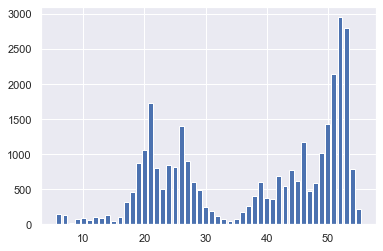

In [345]:
plt.bar(columns_represented.keys(), columns_represented.values())

Next I want to fix problematic columns

In [346]:
# Fix 'Weather Condition' column
df['Weather Condition (Dry or Wet)'].unique()
df = df.replace(['Dry', 'Wet'], ['D', 'W'])

In [348]:
# Check which columns are numeric and create a list of object columns
obj_cols = []
ok_obj_cols = ['Sampling Location', 'Sample Date', 'Sample Time', 'Weather Condition (Dry or Wet)']
for col in df:
    if col not in ok_obj_cols:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            print(col)
            obj_cols.append(col)

Top Sample Photosysthetically Active Radiation Reference (400-700nm light (uE/S)
Top Sample Par (uE/S m2)
Current Speed (knot)
Current Direction (Current Direction)
Wind Speed (mph)
Wind Direction (Wind Direction)
Sea State 
Secchi Depth (ft)
Bottom PH
Top Fecal Coliform Bacteria (Cells/100mL)
Bottom Fecal Coliform Bacteria (Cells/100mL)
Enterococcus Top Sample Less Than or Greater Than Result
Top Enterococci Bacteria (Cells/100mL)
Top Nitrate/Nitrite (mg/L)
Top Ammonium (mg/L)
Top Ortho-Phosphorus (mg/L)
Top Silica (mg/L)
Total Phosphorus(mg/L)
Bottom Total Suspended Solid (mg/L)
Top Active Chlorophyll 'A' (µg/L)
Long
Lat
Type


In [349]:
def col_strip(string):
    '''Strips strings of trailing spaces and returns
    stripped string or numeric value'''
    if type(string) == str:
        string = string.replace(' ', '')
    return string

for col in obj_cols:
    print(col)
    df[col] = df[col].apply(col_strip)
    df[col] = pd.to_numeric(df[col])


Top Sample Photosysthetically Active Radiation Reference (400-700nm light (uE/S)
Top Sample Par (uE/S m2)
Current Speed (knot)


ValueError: Unable to parse string "HWSLK" at position 0

In [350]:
df['Current Speed (knot)']

0        HWSLK
1         weak
2          0.9
3          0.4
4          NaN
5          0.7
6          0.6
7          NaN
8          0.5
9          NaN
10         1.3
11         NaN
12         0.4
13         1.4
14         0.1
15         NaN
16         0.8
17         NaN
18         NaN
19         NaN
20         NaN
21         0.2
22           1
23         3.9
24         2.2
25         0.2
26         0.5
27         0.5
28         0.3
29         NaN
         ...  
30975     WEAK
30976      0.5
30977      NaN
30978      NaN
30979      1.0
30980      0.2
30981     WEAK
30982      2.0
30983      0.6
30984      0.2
30985      0.1
30986      NaN
30987      0.1
30988      NaN
30989      1.0
30990      1.0
30991      0.0
30992      1.6
30993      0.2
30994      0.2
30995      0.1
30996      0.2
30997      1.0
30998      1.2
30999     WEAK
31000      1.5
31001      1.0
31002      0.4
31003      0.2
31004      0.5
Name: Current Speed (knot), Length: 31005, dtype: object

In [295]:
# Drop columns that I don't need
df = df.drop(['Current Direction (Current Direction)', 'Wind Direction (Wind Direction)',
             'Sea State ', 'Type'], axis=1)

Top Sample Par (uE/S m2)
Current Speed (knot)
Wind Speed (mph)
Secchi Depth (ft)
Bottom PH
Top Fecal Coliform Bacteria (Cells/100mL)
Bottom Fecal Coliform Bacteria (Cells/100mL)
Enterococcus Top Sample Less Than or Greater Than Result
Top Enterococci Bacteria (Cells/100mL)
Top Nitrate/Nitrite (mg/L)
Top Ammonium (mg/L)
Top Ortho-Phosphorus (mg/L)
Top Silica (mg/L)
Total Phosphorus(mg/L)
Bottom Total Suspended Solid (mg/L)
Top Active Chlorophyll 'A' (µg/L)
Long
Lat


Next I need to convert the columns to the proper datatype.

In [327]:
# drop trailing spaces from Top Sample Photosynthetically....

col = obj_cols[0]

df[col] = df[col].apply(col_strip)
df[col] = pd.to_numeric(df[col])


In [328]:
df[col]

0        3791.30
1            NaN
2            NaN
3            NaN
4            NaN
5        3223.70
6            NaN
7            NaN
8         313.00
9            NaN
10           NaN
11           NaN
12           NaN
13        176.69
14        135.79
15           NaN
16        129.13
17           NaN
18           NaN
19           NaN
20           NaN
21        193.47
22           NaN
23        757.09
24           NaN
25           NaN
26         41.55
27       1087.70
28       2645.20
29           NaN
          ...   
30975        NaN
30976    2342.00
30977        NaN
30978        NaN
30979    1551.00
30980        NaN
30981        NaN
30982    1850.00
30983        NaN
30984        NaN
30985        NaN
30986        NaN
30987    1662.00
30988        NaN
30989        NaN
30990    2270.00
30991    2139.00
30992    2320.00
30993     472.00
30994     808.00
30995        NaN
30996        NaN
30997    1568.00
30998     640.00
30999        NaN
31000     299.00
31001     909.00
31002    1637.

What would happen if I drop all rows that have fewer than 40 columns present?

In [15]:
drop_cols = []
for i, row in df.iterrows():
    if row.notnull().sum() < 40:
        drop_cols.append(i)
df = df.drop(drop_cols)

In [16]:
df.shape

(16977, 59)

In [17]:
for col in df:
    print(col, df[col].count())

Sampling Location 16977
Sample Date 16977
Sample Time 16977
Weather Condition (Dry or Wet) 16932
Top Sample Temperature (ºC) 16977
Bottom Sample Temperature (ºC) 16757
Site Actual Depth (ft) 16958
Top Sample Depth(ft) 16964
Bottom Sample Depth (ft) 16758
Top Salinity  (psu) 16957
Bottom Salinity  (psu) 16738
Top Conductivity (S/m) 16957
Bottom Conductivity (S/m) 16737
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) 14918
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L) 14689
Percentage O2 Saturation Top Sample 16520
Percentage O2 Saturation Bottom sample 16292
Light Trans (% transparency) Top Sample 11199
Light Trans (% transparency) Bottom Sample 10974
Top Sigma-T (kg/m3) 16875
Bottom Sigma-T (kg/m3) 16662
Top Fluorometer (mg/m3) 14225
Bottom Fluorometer mg/m3 13924
Top Sample Photosysthetically Active Radiation Reference (400-700nm light (uE/S) 10942
Top Sample Par (uE/S m2) 11847
Bottom Sample Par uE/S (uE/S m2) 11621
Oxidati

I want to get an idea of the frequency each site is sampled.

In [18]:
for site in survey_stations:
    site_df = df[df['Sampling Location'] == site]
    print(site, len(site_df), site_df['Sample Date'].min(), site_df['Sample Date'].max())

K1 353 2000-06-27 00:00:00 2018-10-16 00:00:00
K2 348 2000-06-27 00:00:00 2018-10-16 00:00:00
K3 351 2000-06-27 00:00:00 2018-10-16 00:00:00
K4 351 2000-06-27 00:00:00 2018-10-16 00:00:00
K5 353 2000-06-27 00:00:00 2018-10-16 00:00:00
K5A 344 2000-06-27 00:00:00 2018-10-16 00:00:00
K6 320 2000-06-27 00:00:00 2018-10-16 00:00:00
N1 364 2000-02-23 00:00:00 2018-10-22 00:00:00
N3B 379 2000-02-23 00:00:00 2018-10-15 00:00:00
N4 380 2000-02-23 00:00:00 2018-10-15 00:00:00
N5 381 2000-02-23 00:00:00 2019-07-02 00:00:00
N6 350 2000-06-27 00:00:00 2018-10-16 00:00:00
G2 348 2000-06-27 00:00:00 2018-10-16 00:00:00
N7 355 2000-06-27 00:00:00 2018-10-16 00:00:00
N8 348 2000-06-27 00:00:00 2018-10-16 00:00:00
N9 373 2000-03-01 00:00:00 2018-10-18 00:00:00
N16 287 2000-03-01 00:00:00 2018-09-19 00:00:00
NR1 107 2015-04-06 00:00:00 2018-10-22 00:00:00
E2 387 2000-02-23 00:00:00 2018-10-22 00:00:00
E4 388 2000-07-24 00:00:00 2019-07-02 00:00:00
E6 399 2000-06-28 00:00:00 2019-07-02 00:00:00
E7 390 20